In [1]:
from __future__ import annotations

from typing import Tuple, Callable, List

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras

In [2]:
# Mean Squared Error

def mean_squared_error_loss(y: np.ndarray, y_hat: np.ndarray) -> np.ndarray:
    return .5 * (y_hat - y) ** 2


def mean_squared_error_loss_derivative(y: np.ndarray, y_hat: np.ndarray) -> np.ndarray:
    return (y_hat - y)

In [3]:
# Softmax

def logsumexp(x: np.ndarray) -> np.ndarray:
    c = np.max(x, axis=-1, keepdims=True)
    return c + np.log(np.sum(np.exp(x - c), axis=-1, keepdims=True))


def softmax(x: np.ndarray) -> np.ndarray:
    return np.exp(x - logsumexp(x))


def softmax_derivative(z: np.ndarray, y: np.ndarray) -> np.ndarray:
    s = softmax(z)
    c = y - s
    a = np.sum(s * y, axis=-1, keepdims=True) # will be a sparse array that can be flattened

    return a * c

In [4]:
# Categorical Crossentropy

def categorical_crossentropy(y: np.ndarray, y_hat: np.ndarray) -> np.ndarray:
    return -np.sum(y * np.log(y_hat), axis=-1)


def categorical_crossentropy_derivative(y: np.ndarray, y_hat: np.ndarray) -> np.ndarray:
    return - np.max(y / y_hat, axis=-1, keepdims=True)

In [5]:
# Categorical Crossentropy from Logits

def categorical_crossentropy_from_logits(y: np.ndarray, logits: np.ndarray) -> np.ndarray:
    y_hat = logits - logsumexp(logits)
    return -np.sum(y * y_hat, axis=-1)


def categorical_crossentropy_derivative_from_logits(y: np.ndarray, logits: np.ndarray) -> np.ndarray:
    y_hat = softmax(logits)
    return y_hat - y

In [6]:
# Cost

def cost(y: np.ndarray, y_hat: np.ndarray, loss_fn: Callable[[np.ndarray, np.ndarray], np.ndarray]) -> float:
    return np.average(loss_fn(y, y_hat))

In [7]:
# TODO: this should be a test
z = np.asarray([[1, 2, 3, 4, 5], [5, 4, 3, 2, 1]]).astype(float)
y_hat = softmax(z)
y = np.asarray([[1, 0, 0, 0, 0], [0, 0, 0, 0, 1]])

print(y_hat)
print(y)

dy_simple = categorical_crossentropy_derivative_from_logits(y, z)
dy_complex = categorical_crossentropy_derivative(y, y_hat) * softmax_derivative(z, y)
print(dy_simple)
print(dy_complex)

for i in range(dy_simple.shape[0]):
    for j in range(dy_simple.shape[1]):
        assert abs(dy_simple[i][j] - dy_complex[i][j]) < 1e-12

for _ in range(100):
    z -= np.sum(categorical_crossentropy_derivative(y, y_hat) * softmax_derivative(z, y), axis=0)
    y_hat = softmax(z)

print(cost(y, y_hat, categorical_crossentropy))
print(cost(y, z, categorical_crossentropy_from_logits))

[[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]
 [0.63640865 0.23412166 0.08612854 0.03168492 0.01165623]]
[[1 0 0 0 0]
 [0 0 0 0 1]]
[[-0.98834377  0.03168492  0.08612854  0.23412166  0.63640865]
 [ 0.63640865  0.23412166  0.08612854  0.03168492 -0.98834377]]
[[-0.98834377  0.03168492  0.08612854  0.23412166  0.63640865]
 [ 0.63640865  0.23412166  0.08612854  0.03168492 -0.98834377]]
4.024092481453339
4.024092481453339


In [8]:
# TODO: this should be a test
z = np.arange(5).astype(float)
y_hat = softmax(z)

y = np.asarray([1, 0, 0, 0, 0])

dy_simple = categorical_crossentropy_derivative_from_logits(y, z)
dy_complex = categorical_crossentropy_derivative(y, y_hat) * softmax_derivative(z, y)

print(dy_simple)
print(dy_complex)

[-0.98834377  0.03168492  0.08612854  0.23412166  0.63640865]
[-0.98834377  0.03168492  0.08612854  0.23412166  0.63640865]


In [9]:
class Activation(object):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError()


    def derivative(self, x: np.ndarray) -> np.ndarray:
        raise NotImplementedError()


class Sigmoid(Activation):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-x))

    
    def derivative(self, x: np.ndarray) -> np.ndarray:
        return np.exp(x) / (1 + np.exp(x)) ** 2


class Linear(Activation):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return x


    def derivative(self, x: np.ndarray) -> np.ndarray:
        return np.ones_like(x)


class Relu(Activation):
    def __call__(self, x: np.ndarray) -> np.ndarray:
        return (x > 0).astype(np.float32) * x

    
    def derivative(self, x: np.ndarray) -> np.ndarray:
        return (x > 0).astype(np.float32)

In [10]:
class Layer:
    pass

class DenseLayer(Layer):

    def __init__(self, size: Tuple[int, int], activation_fn: Activation=Sigmoid(), rng_seed: int=None):
        super().__init__()
        self.__size = size[1]
        self.__rng = np.random.default_rng() if rng_seed is None else np.random.default_rng(rng_seed)
        self.__activation = activation_fn
        prev_layer_size = size[0]

        self.__w = self.__rng.standard_normal(size=(prev_layer_size, self.__size)) * np.sqrt(2 / prev_layer_size)
        self.__b = np.zeros(self.__size)
    

    def set_weights(self, weights: Tuple[np.ndarray, np.ndarray]) -> None:
        self.__w, self.__b = weights


    def get_weights(self) -> Tuple[np.ndarray, np.ndarray]:
        return self.__w, self.__b


    def get_activation_fn(self) -> Activation:
        return self.__activation


    def get_activation(self) -> np.ndarray:
        return self.__z
    

    def get_prev_activation(self) -> np.ndarray:
        return self.__prev_activation

    
    def __call__(self, X: np.ndarray) -> np.ndarray:
        """
            Defines the forward pass through the layer
        """
        self.__prev_activation = X
        self.__z = np.matmul(X, self.__w) + self.__b
        return self.__activation(self.__z)

In [11]:
rng = np.random.default_rng(0)

X = rng.random(50).reshape((5, 10))
y = rng.normal(size=5).reshape((5, 1))

layer1 = DenseLayer((X.shape[1], 5), Sigmoid(), rng_seed=0)
layer2 = DenseLayer((5, 2), Sigmoid(), rng_seed=0)
layer3 = DenseLayer((2, 1), Sigmoid(), rng_seed=0)

In [12]:
# X [5, 10] * W [10, 5] + b [1, 5] =
# = X*W [5, 5] + b [1, 5] (b is broadcast to all rows so [5, 5]) =
# = X*W+b [5, 5] =
# = sigmoid(X*W+b) [5, 5]

a1 = layer1(X)
print(f'layer1 activations shape: {a1.shape}')


# X [5, 5] * W [5, 2] + b [1, 2] =
# = X*W [5, 2] + b [1, 2] (b is broadcast to all rows so [5, 2]) =
# = X*W+b [5, 2] =
# = sigmoid(X*W+b) [5, 2]
a2 = layer2(a1)
print(f'layer2 activations shape: {a2.shape}')


# X [5, 2] * W [2, 1] + b [1, 1] =
# = X*W [5, 1] + b [1, 1] (b is broadcast to all rows so [5, 1]) =
# = X*W+b [5, 1] =
# = sigmoid(X*W+b) [5, 1]
y_hat = layer3(a2)
print(f'layer3 activations shape: {y_hat.shape}')


error = cost(y, y_hat, mean_squared_error_loss)
error

layer1 activations shape: (5, 5)
layer2 activations shape: (5, 2)
layer3 activations shape: (5, 1)


0.6435413715367675

In [13]:
# Layer L

dc_da3 = mean_squared_error_loss_derivative(y, y_hat)
print(f"dc_da3 shape: {dc_da3.shape}")

a2 = layer3.get_prev_activation()

dc_dz3 = dc_da3 * layer3.get_activation_fn().derivative(layer3.get_activation())
print(f"dc_dz3 shape: {dc_dz3.shape}")
print(f"a2 shape: {a2.shape}")

dc_dw3 = (1 / dc_dz3.shape[0]) * np.matmul(a2.T, dc_dz3)

w3, _ = layer3.get_weights()
print(f"w3 shape: {w3.shape}, dc_dw3 shape: {dc_dw3.shape}")

# Layer L - 1
dc_da2 = np.dot(dc_dz3, w3.T)
print(f"dc_da2 shape: {dc_da2.shape}")

a1 = layer2.get_prev_activation()

dc_dz2 = dc_da2 * layer2.get_activation_fn().derivative(layer2.get_activation())
print(f"dc_dz2 shape: {dc_dz2.shape}")
print(f"a1 shape: {a1.shape}")

dc_dw2 = (1 / dc_dz2.shape[0]) * np.matmul(a1.T, dc_dz2)

w2, _ = layer2.get_weights()
print(f"w2 shape: {w2.shape}, dc_dw2 shape: {dc_dw2.shape}")

# Layer L - 2
dc_da1 = np.matmul(dc_dz2, w2.T)
print(f"dc_da1 shape: {dc_da1.shape}")

a0 = layer1.get_prev_activation()

dc_dz1 = dc_da1 * layer1.get_activation_fn().derivative(layer1.get_activation())
print(f"dc_dz1 shape: {dc_dz1.shape}")
print(f"a0 shape: {a0.shape}")

dc_dw1 = (1 / dc_dz1.shape[0]) * np.matmul(a0.T, dc_dz1)

w1, _ = layer1.get_weights()
print(f"w1 shape: {w1.shape}, dc_dw1 shape: {dc_dw1.shape}")

dc_da3 shape: (5, 1)
dc_dz3 shape: (5, 1)
a2 shape: (5, 2)
w3 shape: (2, 1), dc_dw3 shape: (2, 1)
dc_da2 shape: (5, 2)
dc_dz2 shape: (5, 2)
a1 shape: (5, 5)
w2 shape: (5, 2), dc_dw2 shape: (5, 2)
dc_da1 shape: (5, 5)
dc_dz1 shape: (5, 5)
a0 shape: (5, 10)
w1 shape: (10, 5), dc_dw1 shape: (10, 5)


In [14]:
class NeuralNetwork(object):

    def __init__(self, layers, lr, loss_fn, loss_derivative):
        self.__layers = layers
        self.__loss = loss_fn
        self.__loss_derivative = loss_derivative
        self.__alpha = lr


    def fit(self, X: np.ndarray, y: np.ndarray, num_epochs: int) -> List[float]:
        errors = []

        for i in range(num_epochs):
            y_hat = self.__forward_prop(X)
            error = cost(y, y_hat, self.__loss)
            errors.append(error)

            if i % (num_epochs / 10) == 0:
                print(f'Iter[{i}] cost: {error}')

            self.__back_prop(y, y_hat)
        
        return errors


    def predict(self, X: np.ndarray) -> np.ndarray:
        return self.__forward_prop(X)


    def __forward_prop(self, X: np.ndarray) -> np.ndarray:
        a = X
        for layer in self.__layers:
            a = layer(a)
        
        return a


    def __back_prop(self, y: np.ndarray, y_hat: np.ndarray) -> None:
        dc_da = self.__loss_derivative(y, y_hat)

        for i in range(len(self.__layers) - 1, -1, -1):
            layer = self.__layers[i]
            z = layer.get_activation()
            a_prev = layer.get_prev_activation()
            activation_fn = layer.get_activation_fn()
            w, b = layer.get_weights()

            dc_dz = dc_da * activation_fn.derivative(z)

            dc_dw = np.matmul(a_prev.T, dc_dz)
            dc_db = np.average(dc_dz, axis=0)

            dc_da = np.dot(dc_dz, w.T)

            w -= (self.__alpha / dc_dz.shape[0]) * dc_dw
            b -= self.__alpha * dc_db

            layer.set_weights((w, b))

In [15]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = x_train.astype(np.float32).reshape(-1, 28 * 28) / 255.0
x_test = x_test.astype(np.float32).reshape(-1, 28 * 28) / 255.0

print(x_train.shape)
print(x_test.shape)

y_train_temp = np.zeros((y_train.shape[0], 10))
for i in range(len(y_train)):
    y_train_temp[i, y_train[i]] = 1
y_train = y_train_temp

y_test_temp = np.zeros((y_test.shape[0], 10))
for i in range(len(y_test)):
    y_test_temp[i, y_test[i]] = 1
y_test = y_test_temp

print(y_train.shape)
print(y_test.shape)

(60000, 784)
(10000, 784)
(60000, 10)
(10000, 10)


In [16]:
print(y_train[0:5])
print(y_test[0:5])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [17]:
lr = 1e-1
num_epochs = 100

layers = [
    DenseLayer((x_train.shape[1], 16), Relu(), rng_seed=0),
    DenseLayer((16, 16), Relu(), rng_seed=0),
    DenseLayer((16, 10), Linear(), rng_seed=0),
]
model = NeuralNetwork(layers, lr, categorical_crossentropy_from_logits, categorical_crossentropy_derivative_from_logits)
errors = model.fit(x_train, y_train, num_epochs=num_epochs)

Iter[0] cost: 2.424698493286523
Iter[10] cost: 2.092756039912454
Iter[20] cost: 1.8382835088603404
Iter[30] cost: 1.5732895183858826
Iter[40] cost: 1.2815092739073126
Iter[50] cost: 1.022274695881179
Iter[60] cost: 0.8502256408534357
Iter[70] cost: 0.7378234170802949
Iter[80] cost: 0.6589234775782974
Iter[90] cost: 0.6002947751830296


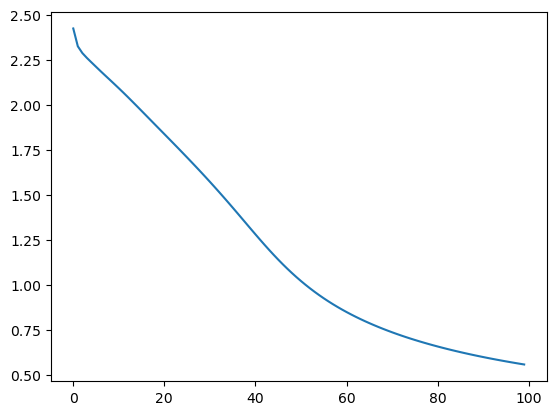

In [18]:
fig, ax = plt.subplots()

ax.plot(np.arange(len(errors)), errors)

plt.show()

In [19]:
y_hat = model.predict(x_test)
print(cost(y_test, y_hat, categorical_crossentropy_from_logits))
print(np.argmax(y_test[:5], axis=1))
print(np.argmax(y_hat[:5], axis=1))

0.5232196052914823
[7 2 1 0 4]
[7 2 1 0 4]


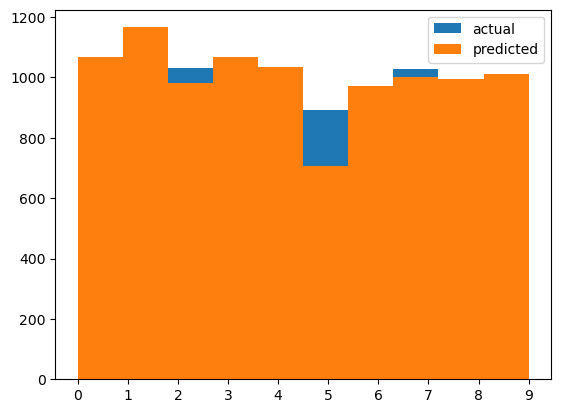

In [20]:
fig, ax = plt.subplots()

ax.hist(np.argmax(y_test, axis=1), label='actual', bins=10)
ax.hist(np.argmax(y_hat, axis=1), label='predicted', bins=10)

ax.legend()
ax.set_xticks(np.arange(0, 10))

plt.show()

In [21]:
model = keras.Sequential([
    keras.layers.Input(28 * 28),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(10, activation='linear')
])

model.compile(loss=keras.losses.CategoricalCrossentropy(from_logits=True), optimizer=keras.optimizers.SGD(1e-1))
model.fit(x_train, y_train, batch_size=60000, epochs=100)


Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 2.3240
Epoch 2/100
1/1 [==============================] - 0s 129ms/step - loss: 2.3087
Epoch 3/100
1/1 [==============================] - 0s 131ms/step - loss: 2.2979
Epoch 4/100
1/1 [==============================] - 0s 154ms/step - loss: 2.2889
Epoch 5/100
1/1 [==============================] - 0s 249ms/step - loss: 2.2807
Epoch 6/100
1/1 [==============================] - 0s 170ms/step - loss: 2.2728
Epoch 7/100
1/1 [==============================] - 0s 197ms/step - loss: 2.2647
Epoch 8/100
1/1 [==============================] - 0s 190ms/step - loss: 2.2563
Epoch 9/100
1/1 [==============================] - 0s 224ms/step - loss: 2.2472
Epoch 10/100
1/1 [==============================] - 0s 226ms/step - loss: 2.2374
Epoch 11/100
1/1 [==============================] - 0s 142ms/step - loss: 2.2267
Epoch 12/100
1/1 [==============================] - 0s 164ms/step - loss: 2.2149
Epoch 13/100
1/1 [======================

In [22]:
y_hat = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


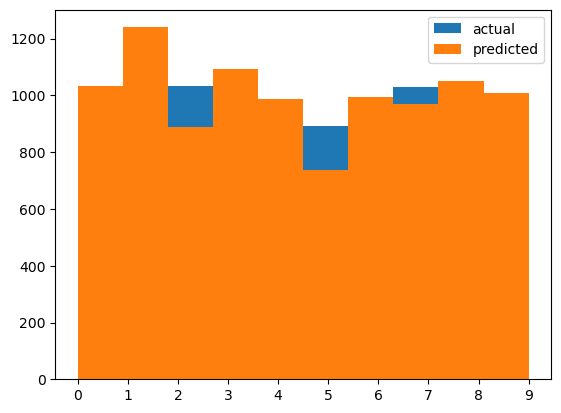

In [23]:
fig, ax = plt.subplots()

ax.hist(np.argmax(y_test, axis=1), label='actual')
ax.hist(np.argmax(y_hat, axis=1), label='predicted')

ax.legend()
ax.set_xticks(np.arange(0, 10))

plt.show()